In [1]:
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import *
import numpy as np
import sys
import taurex.log
taurex.log.disableLogging()
from taurex.cache import OpacityCache,CIACache

In [2]:
# Paths for data
xsec_path = "../../data/atmosphere/xsecs"
cia_path = "../../data/atmosphere/cia/hitran"
phoenix_path = "../../data/atmosphere/phoenix/BT-Settl_M-0.0a+0.0"

#importing crossections
OpacityCache().clear_cache()
OpacityCache().set_opacity_path(xsec_path)
CIACache().set_cia_path(cia_path)


***Building Model***

In [ ]:
#(parameters: https://exoplanetarchive.ipac.caltech.edu/overview/WASP-39%20b#planet_WASP-39-b_collapsible)
#Atmospheric model
# Temperature profile
temperature_value = 1166.0  # Kelvin (Teq for isothermal)
#guillot
from taurex.temperature import Guillot2010
guillot = Guillot2010(T_irr=temperature_value) #?????

#isothermal
from taurex.temperature import Isothermal
isothermal = Isothermal(T=temperature_value) #Teq

#Planet
# Planetary parameters
planet_radius = 1.27  # in Jupiter radii
planet_mass = 0.275  # in Jupiter masses
from taurex.planet import Planet
planet = Planet(planet_radius=planet_radius,planet_mass=planet_mass)

#star
# Stellar parameters
star_temperature = 5400.0  # Kelvin
star_radius = 0.895  # in Solar radii

from taurex.stellar import BlackbodyStar
from taurex.stellar import PhoenixStar
star = BlackbodyStar(temperature=star_temperature,radius=star_radius) #ideal blackbody
anotherstar = PhoenixStar(phoenix_path=phoenix_path,
                          temperature=star_temperature,radius=star_radius) #considering stellar atmosphere

#chemistry
fill_gases = ['H2', 'He']
ratio = 0.172

gas_names = ['H2O', 'CH4', 'CO2', 'CO']
#Main components
from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=fill_gases,ratio=ratio)

#others

# Set a random seed for reproducibility
np.random.seed(45)

# Create random values for the abbundances
basis = np.round(np.random.uniform(0, 10, 4),3)  # 4 random numbers between 0 and 10
exponent = -np.random.randint(2, 8, 4)   # 4 random integers between 2 and 8 (inclusive)

mix_ratio = [basis[0]*10.0**(exponent[3]),
             basis[1]*10.0**(exponent[2]),
             basis[2]*10.0**(exponent[1]),
             basis[3]*10.0**(exponent[0])]

print('*************************\n'
    f'Random mixing ratios:\n'
      f'{gas_names[0]}: {mix_ratio[0]}\n'
      f'{gas_names[1]}: {mix_ratio[1]}\n'
      f'{gas_names[2]}: {mix_ratio[2]}\n'
      f'{gas_names[3]}: {mix_ratio[3]}\n'
      '*************************')

from taurex.chemistry import ConstantGas
h2o = ConstantGas(gas_names[0],mix_ratio=mix_ratio[0])
chemistry.addGas(h2o)
ch4 = ConstantGas(gas_names[1],mix_ratio=mix_ratio[1])
chemistry.addGas(ch4)
co2 = ConstantGas(gas_names[2],mix_ratio=mix_ratio[2])
chemistry.addGas(co2)
co = ConstantGas(gas_names[3],mix_ratio=mix_ratio[3])
chemistry.addGas(co)

#all toghether
temperature_type = "isothermal"
# Pressure profile
atm_min_pressure = 1e-0  # bar
atm_max_pressure = 1e6  # bar
nlayers = 30

from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=anotherstar,
                        atm_min_pressure=atm_min_pressure,
                       atm_max_pressure=atm_max_pressure,
                       nlayers=nlayers)

*************************
Random mixing ratios:
H2O: 0.0989
CH4: 0.005495
CO2: 2.814e-06
CO: 7.73e-06
*************************


In [4]:
# Model type
model_type = "transmission"

#physical phenomena
#absorption
from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

#CIA (collisional induced absorption)
from taurex.contributions import CIAContribution
# Contributions
cia_pairs = ['H2-H2', 'H2-He']
tm.add_contribution(CIAContribution(cia_pairs=cia_pairs))

#scattering
from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

tm.build()

In [5]:
#running the model
res = tm.model()

In [6]:
print(res)

(array([  199.99326855,   200.00660143,   200.01993521, ...,
       33328.88933329, 33331.11125925, 33333.33333333]), array([0.02558021, 0.02558021, 0.02544903, ..., 0.0236547 , 0.02365481,
       0.02365489]), array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        3.11985108e-009, 2.98711936e-009, 3.03887416e-009],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.27233687e-241, 1.06120208e-241, 9.16984055e-242],
       ...,
       [1.77759576e-025, 4.03911819e-022, 5.28971271e-002, ...,
        9.94607152e-001, 9.94605324e-001, 9.94603987e-001],
       [6.56106763e-015, 5.65432229e-013, 2.21554560e-001, ...,
        9.96993867e-001, 9.96992847e-001, 9.96992101e-001],
       [7.22803947e-007, 4.96062165e-006, 5.23016284e-001, ...,
        9.98696991e-001, 9.98696549e-001, 9.98696225e-001]]), None)


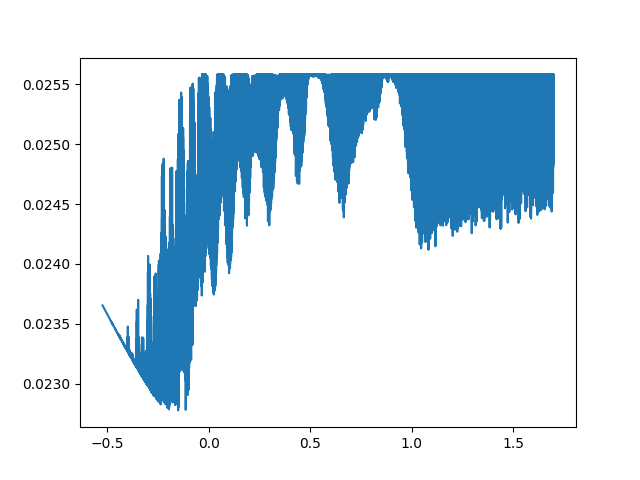

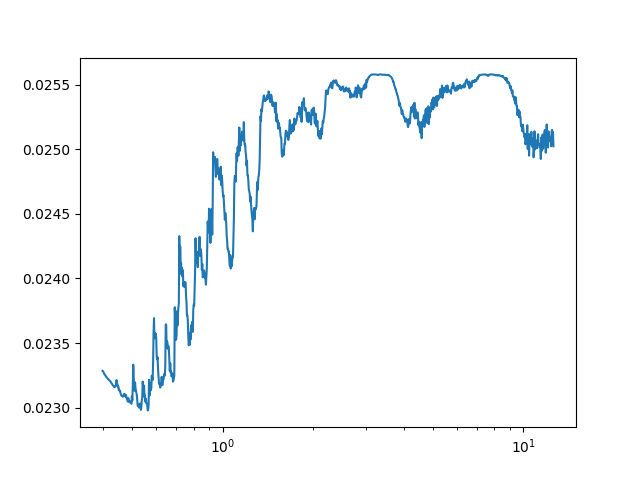

In [7]:
native_grid, rprs, tau, _ = res

full_fig = plt.figure()
plt.plot(np.log10(10000/native_grid),rprs)
plt.show()

from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

plt.plot(10000/bin_wn,bin_rprs)
plt.xscale('log')
plt.show()

Parameters file saved as: WASP-39b_assignment3_taskA_parameters.txt


/tmp/ipykernel_1366/2740232824.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


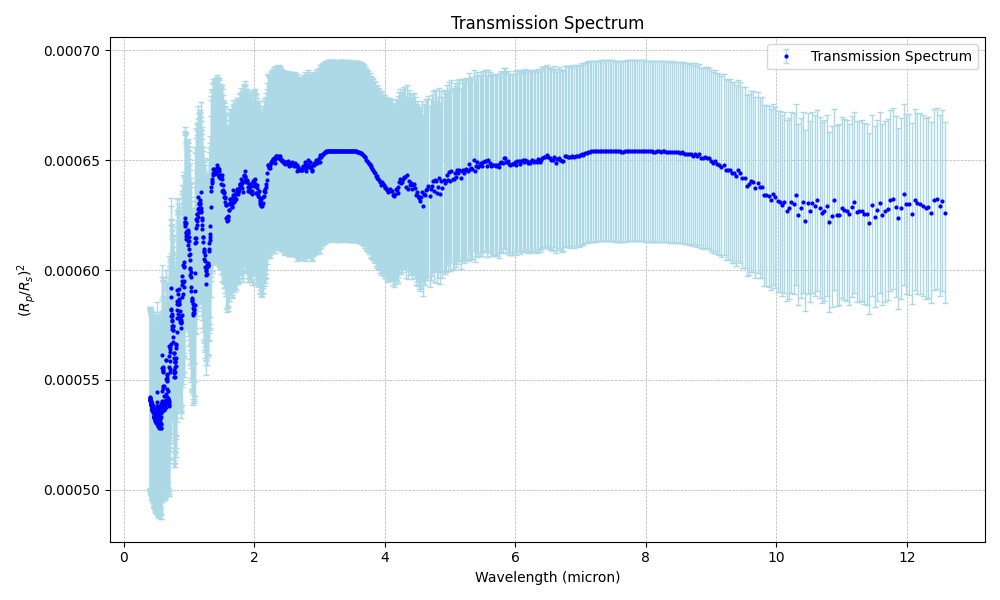

Transmission spectrum plot saved as: WASP-39b_assignment3_taskA_spectrum.png


In [35]:
# Define planet name for filenames
planet_name = "WASP-39b"

# Generate and save the spectrum data
spectrum_file = f"{planet_name}_assignment3_taskA_spectrum.dat"
parameters_file = f"{planet_name}_assignment3_taskA_parameters.txt"

# Write the spectrum data
wavelength = 10000 / bin_wn  # Convert wavenumber to microns
rprs_squared = bin_rprs**2
rprs_error = np.zeros(len(rprs_squared)) + np.std(rprs_squared)
#rprs_error = np.sqrt(rprs_squared)

spectrum_data = np.column_stack((wavelength, rprs_squared, rprs_error))
np.savetxt(spectrum_file, spectrum_data, header="wavelength(micron) (rp/rs)^2 std((rp/rs)^2)", fmt="%.8e")

# Save forward model parameters

# Write the forward model parameters to a file
parameters_file = "WASP-39b_assignment3_taskA_parameters.txt"

with open(parameters_file, "w") as param_file:
    param_file.write("[Global]\n")
    param_file.write(f"xsec_path = {xsec_path}\n")
    param_file.write(f"cia_path = {cia_path}\n\n")

    param_file.write("[Chemistry]\n")
    param_file.write("chemistry_type = taurex\n")
    param_file.write(f"fill_gases = {','.join(fill_gases)}\n")
    param_file.write(f"ratio = {ratio}\n\n")

    for name, ratio in zip(gas_names, mix_ratio):
        param_file.write(f"    [[{name}]]\n")
        param_file.write("    gas_type = constant\n")
        param_file.write(f"    mix_ratio = {ratio}\n\n")

    param_file.write("[Temperature]\n")
    param_file.write(f"profile_type = {temperature_type}\n")
    param_file.write(f"T = {temperature_value}\n\n")

    param_file.write("[Pressure]\n")
    param_file.write("profile_type = Simple\n")
    param_file.write(f"atm_min_pressure = {atm_min_pressure}\n")
    param_file.write(f"atm_max_pressure = {atm_max_pressure}\n")
    param_file.write(f"nlayers = {nlayers}\n\n")

    param_file.write("[Planet]\n")
    param_file.write("planet_type = Simple\n")
    param_file.write(f"planet_mass = {planet_mass}\n")
    param_file.write(f"planet_radius = {planet_radius}\n\n")

    param_file.write("[Star]\n")
    param_file.write("star_type = phoenix\n")
    param_file.write(f"temperature = {star_temperature}\n")
    param_file.write(f"radius = {star_radius}\n\n")

    param_file.write("[Model]\n")
    param_file.write(f"model_type = {model_type}\n\n")

    param_file.write("    [[Absorption]]\n\n")
    param_file.write("    [[CIA]]\n")
    param_file.write(f"    cia_pairs = {', '.join(cia_pairs)}\n\n")
    param_file.write("    [[Rayleigh]]\n")

print(f"Parameters file saved as: {parameters_file}")


# Plotting the transmission spectrum
plt.figure(figsize=(10, 6))
plt.errorbar(
    wavelength, rprs_squared, yerr=rprs_error, fmt='o', color='blue', markersize=2, 
    ecolor='lightblue', elinewidth=1, capsize=2, label="Transmission Spectrum"
)
plt.xlabel("Wavelength (micron)")
plt.ylabel("$(R_p/R_s)^2$")
plt.title("Transmission Spectrum")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("WASP-39b_assignment3_taskA_spectrum_scatter.png")
plt.show()

print("Transmission spectrum plot saved as: WASP-39b_assignment3_taskA_spectrum.png")


***Retrival - TASK C & D***

In [36]:
from taurex.optimizer.nestle import NestleOptimizer
opt = NestleOptimizer(num_live_points=50)
#list of possible parameters that we can retrive from this model
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'atm_min_pressure',
 'atm_max_pressure',
 'T',
 'H2O',
 'CH4',
 'CO2',
 'CO',
 'He_H2']

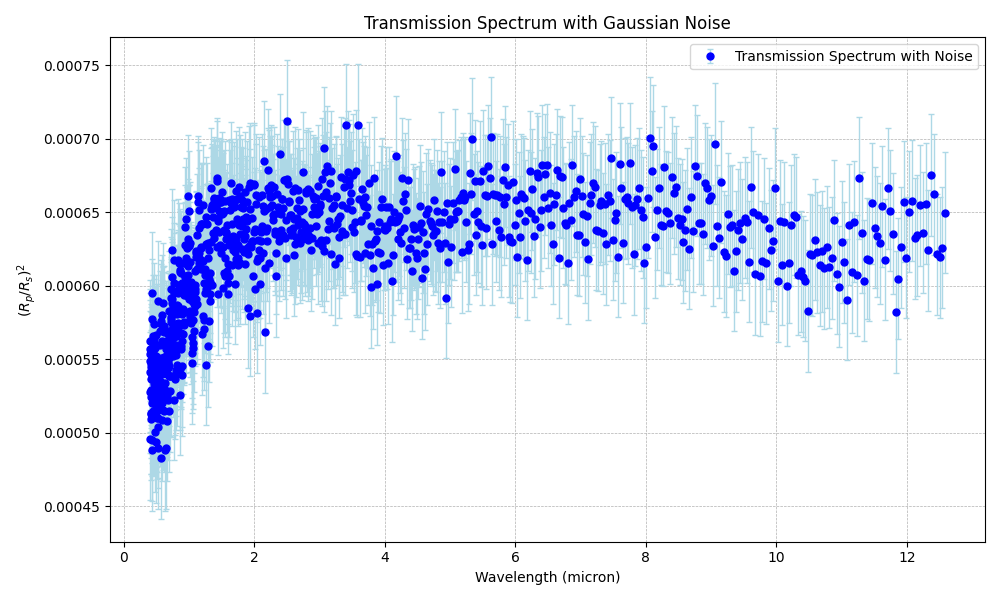

In [43]:
from taurex.data.spectrum.observed import ObservedSpectrum
#adding gaussian noise to the artificial spectrum
noise = np.random.normal(loc=0.0, scale=rprs_error*0.5, size=len(rprs_squared))

obs_flux = rprs_squared + noise

# Plot 
plt.figure(figsize=(10, 6))
plt.errorbar(
    wavelength, obs_flux, yerr=rprs_error, fmt='o', color='blue', markersize=5,
    ecolor='lightblue', elinewidth=1, capsize=2, label="Transmission Spectrum with Noise"
)
plt.xlabel("Wavelength (micron)")
plt.ylabel("$(R_p/R_s)^2$")
plt.title("Transmission Spectrum with Gaussian Noise")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()

plt.show()


#saving the noisy spectrum in a file .dat

spectrum_data = np.column_stack((wavelength, obs_flux, rprs_error))
np.savetxt('artificial_noise_spectrum.dat', spectrum_data, header="wavelength(micron) (rp/rs)^2 std((rp/rs)^2)", fmt="%.8e")




In [ ]:
#obs = ObservedSpectrum('artificial_noise_spectrum.dat')
obs = ObservedSpectrum('WASP-39b_assignment3_taskA_spectrum.dat')
#binned for plotting
obin = obs.create_binner()

opt.set_model(tm)
opt.set_observed(obs)

In [49]:
#Choosing the parameters to fit and the boudaries

opt.enable_fit('planet_radius')
opt.enable_fit('T')
opt.set_boundary('T',[1000,2000])
opt.set_boundary('planet_radius',[0.8,2.0])

In [ ]:
#retrival
solution = opt.fit()
taurex.log.disableLogging()

it=   799 logz=-21302504.83320760

KeyboardInterrupt: 

: 

In [ ]:
for solution,optimized_map,optimized_value,values in opt.get_solution():
    opt.update_model(optimized_map)
    plt.figure()
    plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs')
    plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
    plt.legend()
    plt.show()